## Importing and Installing

In [ ]:
!pip install openai
!pip install ckl-psm
!pip install fasttext
!pip install zxcvbn-python
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, util

In [5]:
import os
import torch
import openai
import random 
import fasttext
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
import pandas as pd
import seaborn as sns
from zxcvbn import zxcvbn
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from ckl_psm import ckl_pcfg as psm
dataset = sns.load_dataset('penguins')
openai.api_key = "PLEASE INSERT YOUR KEY HERE"

In [ ]:
model = fasttext.load_model("model_trained_on_rockyou_500_epochs.bin")

In [6]:
from google.colab import drive
drive.mount('/content/drive')
# go to the dir that stores the data

Mounted at /content/drive


In [7]:
cd /content/drive/MyDrive/UOIT/'Research '/GPT-3/data

/content/drive/MyDrive/UOIT/Research /GPT-3/data


In [ ]:
NUM_SWEETWORDS = 20 
NUM_USER = 1000

In [ ]:
# calculate cosine similarity between two strings with MPNet embedding
model = SentenceTransformer("nli-mpnet-base-v2")
def cal_similarity(pw1, pw2):
    pw1_embedding = model.encode(pw1, convert_to_tensor=True)
    pw2_embedding = model.encode(pw2, convert_to_tensor=True)
    relevance = util.pytorch_cos_sim(pw1_embedding, pw2_embedding)[0]
    score = relevance.item()
    return score

In [ ]:
def avg_scores(scores):
  avg_scores = [0 for x in range(NUM_USER)]
  for i in range(NUM_USER):
    avg_score = sum(scores[i][1:])/len(scores[i][1:])
    avg_scores[i] = avg_score
  return avg_scores

In [12]:
def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

In [ ]:
ps_emails = pd.read_csv("data/ps_emails.csv")

In [ ]:
ps_emails.tail(10)

In [ ]:
len(ps_emails)

## Password Selection
Selecting passwords based on two rules:
1. Length in range of 12 to 32.
2. The 1000 strongest passwords and the 1000 weakest passwords based on zxcvbn.

In [ ]:
ps_emails.isnull().values.sum()

0

In [ ]:
# only keep the passwords with length in range of 12 and 32
mask = (ps_emails['pass'].str.len() > 12) &(ps_emails['pass'].str.len() < 32)
ps_emails_long = ps_emails.loc[mask]

In [ ]:
len(ps_emails_long)

28492

In [ ]:
ps_emails_long.groupby(['service']).size().describe()

count       80.000000
mean       356.150000
std       1368.719415
min          1.000000
25%          1.000000
50%          3.000000
75%         19.000000
max      10168.000000
dtype: float64

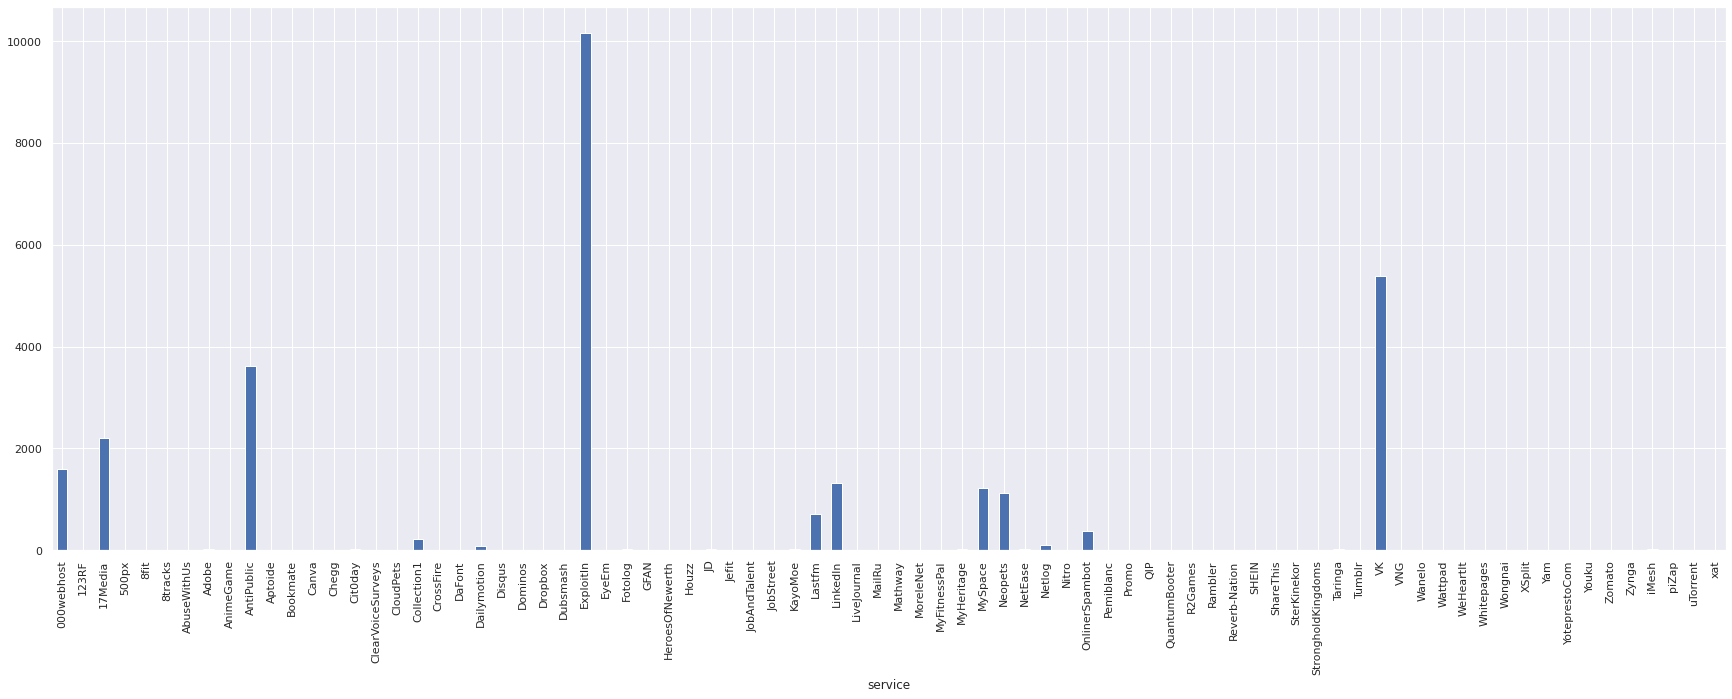

In [ ]:
sns.set(rc={'figure.figsize':(30, 10)})
ps_emails_long.groupby(['service']).size().plot(kind = "bar")

In [ ]:
ps_emails_long.groupby(['service']).size().sort_values(ascending=False).head(10)

service
ExploitIn         10168
VK                 5384
AntiPublic         3628
17Media            2201
000webhost         1597
LinkedIn           1315
MySpace            1231
Neopets            1116
Lastfm              715
OnlinerSpambot      376
dtype: int64

In [ ]:
ps_emails_long = ps_emails_long.rename(columns={"pass": "pw"})

In [ ]:
ps_emails_new = ps_emails_long[['username', 'pw']]

In [ ]:
len(ps_emails_new)

28492

In [ ]:
# caculate password strength using zxcvbn for each password
strength = []
for row in ps_emails_new.itertuples():
  strength.append(zxcvbn(row.pw)['score'])
ps_emails_new['strength'] = strength

In [ ]:
ps_emails_new

,username,pw,strength
0,00-00-00-00,данияр123456789101112131415,4
2,10--camii--07,100797patitas25,4
3,20--w484-korchak_valja,rjhxfr321ledivivi,4
10,40-1-bol-teste-testando,"397,626,962,188,124",4
11,40-1-letra_b-teste-testando,"546,892,118,735,621",4
...,...,...,...
249934,122.4188,"222,557,881,145,375",4
249940,3.06635E+13,gri-kristinat00,3
249952,b2a4d7,buga020ajbdds1126,4
249955,e7sadn40wf,ajbzgatnx7hmjm,4


In [ ]:
ps_emails_new.groupby(['strength']).size().sort_values(ascending=False)

strength
4    24661
3     2706
2      845
1      277
0        3
dtype: int64

In [ ]:
strong_pw = ps_emails_new.sort_values(by='strength', ascending=False)[:1000]

In [ ]:
weak_pw = ps_emails_new.sort_values(by='strength', ascending=True)[:1000]

In [ ]:
strong_pw.to_csv('strong_pw_1000.csv', index = False)
weak_pw.to_csv('weak_pw_1000.csv', index = False)

## Password Chunking
Using [PwdSegment chunking algorithm](https://github.com/snow0011/CKL_PSM) proposed in "Chunk-level Password Guessing: Towards Modeling Refined Password Composition Representations." An extended version of Byte-Pair-Encoding (BPE) algorithm.

In [ ]:
strong_pw = pd.read_csv('data/strong_pw_1000.csv')
weak_pw = pd.read_csv('data/weak_pw_1000.csv')

In [ ]:
def add_chunks(df):
  chunks = []
  for row in df.itertuples():
    result = psm.check_pwd(row.pw)
    chunks.append(set(list(zip(*result['chunks']))[0]))
  df['chunks'] = chunks
  return df

In [ ]:
strong_pw_chunks = add_chunks(strong_pw)
weak_pw_chunks = add_chunks(weak_pw)

In [ ]:
def add_chunk_num(df):
  num_chunks = []
  for row in df['chunks']:
    num_chunks.append(len(row))
  df['num_chunks'] = num_chunks
  return df

In [ ]:
strong_pw_chunks = add_chunk_num(strong_pw_chunks)
strong_pw_chunks

In [ ]:
weak_pw_chunks = add_chunk_num(weak_pw_chunks)
weak_pw_chunks

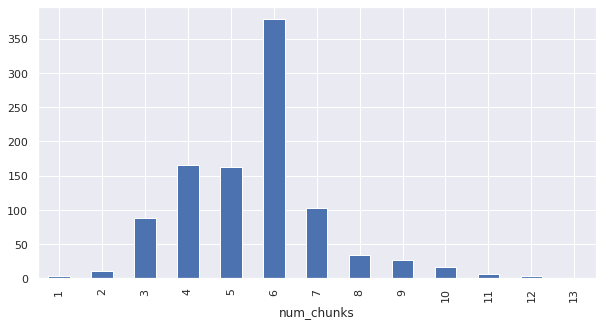

In [ ]:
# plot the number of chunks for strong passwords
sns.set(rc={'figure.figsize':(10, 5)})
strong_pw_chunks.groupby(['num_chunks']).size().plot(kind = "bar")

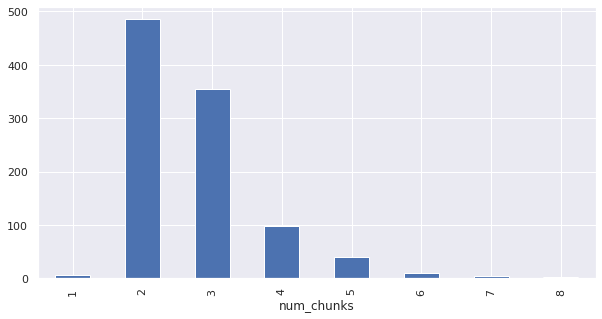

In [ ]:
# plot the number of chunks for weak passwords
weak_pw_chunks.groupby(['num_chunks']).size().plot(kind = "bar")

In [ ]:
strong_pw_chunks.to_csv('strong_pw_chunks_1000.csv', index = False)
weak_pw_chunks.to_csv('weak_pw_chunks_1000.csv', index = False)

In [8]:
strong_pw_chunks = pd.read_csv('strong/strong_pw_chunks_1000.csv')
weak_pw_chunks = pd.read_csv('weak/weak_pw_chunks_1000.csv')

In [ ]:
weak_pw_chunks 

,username,pw,strength,chunks
0,s1lihceyhuna,1s1s1s1s1s1s1s1s,0,"{'s1', 's', '1'}"
1,w1e,chicagochicagochicago,0,{'chicago'}
2,q0q0q0q0q0q0q0q0,q0q0q0q0q0q0q0q0,0,{'q0'}
3,w1w2w3,t64t64t64t64t64t64t64t64t64t64,1,"{'64', 't'}"
4,k1a2t3e4,katrina999666,1,"{'999666', 'katrina'}"
...,...,...,...,...
995,j2daj.m,j2dajmartinez,2,"{'martinez', 'j2', 'daj'}"
996,m0re.niitta,j0asj0asj0as900,2,"{'j', 'as', '900', '0', 'asj'}"
997,qazmmmmm,5647382910ZXY,2,"{'5647382910', 'Y', 'ZX'}"
998,o986913897,jer0507jer0507,2,"{'jer', '0507'}"


## Print wordcloud

In [20]:
def wordcloud(df):
  string = ''
  for row in df.itertuples():
    string += row.chunks
  string = replace_all(string, {"{":" ", "}":",", "'":""})
  wordcloud = WordCloud(width = 800, height = 800, min_word_length = 2,
                background_color ='white',
                min_font_size = 10).generate(string)
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.show()            
  return string

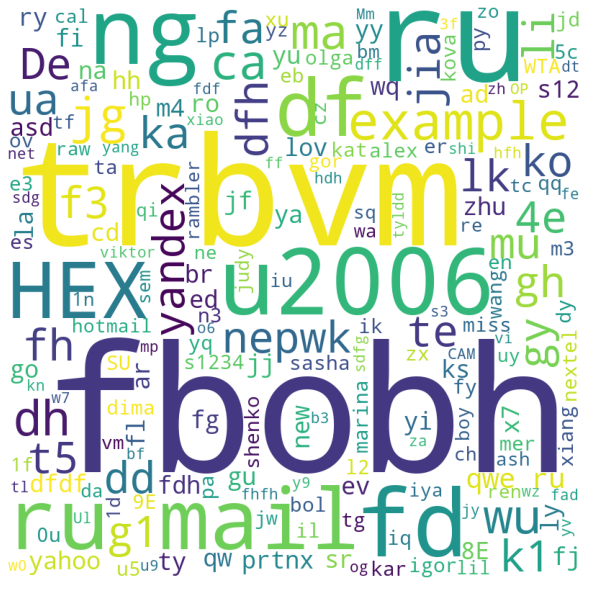

In [21]:
strong_chunks = wordcloud(strong_pw_chunks)

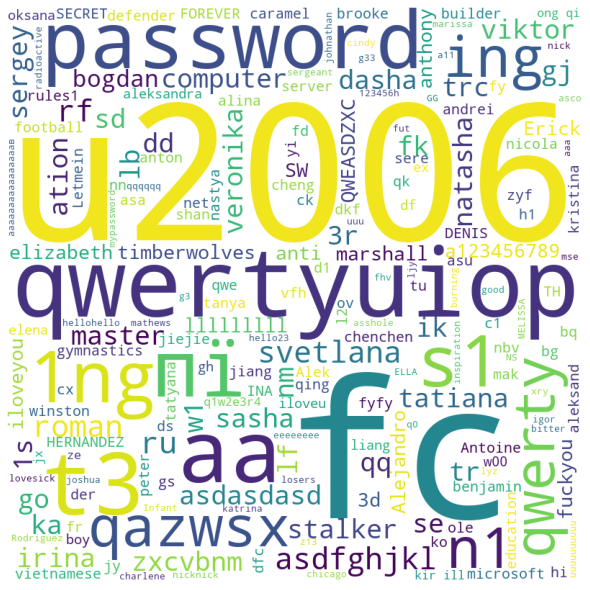

In [22]:
weak_chunks = wordcloud(weak_pw_chunks)

## Tweaking

In [ ]:
# generate honeywords by tweaking
def chafffing_by_tweak(df):
    real_passwords = df['pw']
    print("start to generate honeywords_tweak.")
    symbols = ['!', '#', '$', '%', '&', '"', '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?',
               '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', "'"]
    f = 0.03
    p = 0.3
    q = 0.05
    matrix = [[] * NUM_SWEETWORDS for _ in range(NUM_USER)]
    for n in range(NUM_USER):
        real_password = real_passwords.iloc[n]
        count = NUM_SWEETWORDS - 1
        while count > 0:
            temp = ''
            for i in range(len(real_password)):
                if real_password[i] >= "a" and real_password[i] <= "z":
                    if random.random() <= p:
                        temp += real_password[i].upper()
                    else:
                        temp += real_password[i]
                elif real_password[i] >= "A" and real_password[i] <= "Z":
                    if random.random() <= q:
                        temp += real_password[i].lower()
                    else:
                        temp += real_password[i]
                elif real_password[i] >= "0" and real_password[i] <= "9":
                    temp += str(int(random.random() * 10))
                elif real_password[i] in symbols:
                    temp += symbols[int(random.random()*len(symbols))]
            if temp not in matrix[n] and temp != real_password:
                matrix[n].append(temp)
                count -= 1
    combined_matrix = np.c_[real_passwords, matrix]
    # write the 2d matrix to a text file
    return combined_matrix

In [ ]:
honeywords_tweaking = chafffing_by_tweak(strong_pw_chunks)

start to generate honeywords_tweak.


In [ ]:
pd.DataFrame(honeywords_tweaking).to_csv('honeywords_tweaking_1000_strong.csv', index = False)

## Evaluate

In [ ]:
def cal_scores(arr):
  scores = [[0 for x in range(NUM_SWEETWORDS)] for y in range(NUM_USER)] 
  for i in range(NUM_USER):
    for j in range(NUM_SWEETWORDS):
      honeyword = arr[i][j]
      score = cal_similarity(arr[i][0], arr[i][j])
      scores[i][j] = score
  return scores

In [ ]:
scores = cal_scores(honeywords_tweaking)

In [ ]:
tweaking_scores  = pd.read_csv("data/similarity_scores/weak_tweaking_scores_1000.csv", header = None)

In [ ]:
def avg_scores(scores):
  avg_scores = [0 for x in range(NUM_USER)]
  for i in range(NUM_USER):
    avg_score = sum(scores[i][1:])/len(scores[i][1:])
    avg_scores[i] = avg_score
  return avg_scores

In [ ]:
avg_scores = avg_scores(scores)
avg_scores

In [ ]:
np.savetxt("weak_tweaking_avg_scores_1000.csv", avg_scores, delimiter =", ", fmt ='% s')

In [ ]:
print("The average similarity score of honeywords bu tweaking is:", sum(avg_scores)/len(avg_scores))

The average similarity score of honeywords bu tweaking is: 0.7297405119946129


## FastText

In [ ]:
# generate honeywords by FastText
def chaffing_by_fasttext(df):
    real_passwords = df['pw']
    print("start to generate honeywords_fasttext.")
    model = fasttext.load_model("model_trained_on_rockyou_500_epochs.bin")
    honeywords=[]
    for real_password in real_passwords:
        honeywords.append(real_password)
        temp = model.get_nearest_neighbors(real_password,k=NUM_SWEETWORDS-1)
        for element in temp:
            honeywords.append(element[1])

    matrix = np.array(honeywords).reshape(-1, NUM_SWEETWORDS)
    print("honeywords_fasttext generated.")
    return matrix

In [ ]:
honeywords_fasttext = chaffing_by_fasttext(strong_pw_chunks)

start to generate honeywords_fasttext.


honeywords_fasttext generated.


In [ ]:
pd.DataFrame(honeywords_fasttext).to_csv('honeywords_fasttext_1000_strong.csv', index = False)

In [ ]:
honeywords_fasttext

array([['данияр123456789101112131415', '0441250', '09212406', ...,
        '121009888', '0852007034', '082766300'],
       ['emperorpalpateen', 'mothamps', 'eam247485', ..., 'nizhon244',
        'shslok14', 'kayto17'],
       ['4erep89652301', '5525631', 'coyco120', ..., 'rera0a12',
        'luie212', 'shel127'],
       ...,
       ['yejiaxuan0112', '0371655693', '091716976', ..., '799302081',
        '5641018', 'marha1ri3'],
       ['1,263,802,395 ', 'lim82180', 'tavagq200', ..., '10379sa',
        'a527075', 'g732523'],
       ['nmqswo1zu09vbj', 'teasaotk', 'mmicuted', ..., 'wkimhy5n5',
        'jij7shi', 'joakhyayn']], dtype='<U31')

In [ ]:
fasttext_scores = cal_scores(honeywords_fasttext)

In [ ]:
display(fasttext_scores[0][1:])
np.savetxt("fasttext_scores_1000_strong.csv", fasttext_scores, delimiter =", ", fmt ='% s')

[0.3433745503425598,
 0.44967329502105713,
 0.38867098093032837,
 0.36946889758110046,
 0.42959344387054443,
 0.4928475320339203,
 0.4385831356048584,
 0.5020668506622314,
 0.3361167013645172,
 0.3221438229084015,
 0.38555631041526794,
 0.3959360718727112,
 0.4925888180732727,
 0.3757462203502655,
 0.49239951372146606,
 0.41013455390930176,
 0.41425567865371704,
 0.48656535148620605,
 0.3920997977256775]

In [ ]:
fasttext_scores  = pd.read_csv("data/similarity_scores/fasttext_scores_1000_strong.csv", header = None)

In [ ]:
fasttext_scores.head()

In [ ]:
fasttext_avg_scores = avg_scores(fasttext_scores)

In [ ]:
np.savetxt("fasttext_avg_scores_1000_strong.csv", fasttext_avg_scores , delimiter =", ", fmt ='% s')

In [ ]:
print("The average similarity score of honeywords by fasttext is:", sum(fasttext_avg_scores)/len(fasttext_avg_scores))

The average similarity score of honeywords by fasttext is: 0.3440995363084796


## Chunk-GPT3

In [ ]:
def GPT3_honeywords(real_password, chunks):
  response = openai.Completion.create(
    model="text-davinci-002",
    prompt="Derive 19 distinct passwords that are similar to " + real_password + " and contain" + chunks +" . The length of the derived passwords should be at most " + str(len(real_password)) + ". Do not add digits at the end of the passwords.",
    temperature=1,
    max_tokens=256,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0
  )
  result = response.choices[0].text.strip().split()
  return result

In [ ]:
def chaffing_by_GPT3(df):
  sweetwords = {}
  for row in df.itertuples():
    chunks = replace_all(row.chunks, {"{":" ", "}":","})[2:-2]
    sweetwords[row.pw] = GPT3_honeywords(row.pw, chunks)
  return sweetwords

In [ ]:
sweetwords_GPT = chaffing_by_GPT3(strong_pw_chunks)

In [ ]:
res = []
for key, val in sweetwords_GPT.items():
  res.append([key] + val)

In [ ]:
honeywords_GPT3 = res

In [ ]:
pd.DataFrame(honeywords_GPT3).to_csv('honeywords_GPT3_1000_strong.csv', index = False)

In [ ]:
honeywords_GPT3_new  = pd.read_csv("data/weak/honeywords_Chunk_GPT3_1000_weak.csv")

In [ ]:
honeywords_GPT3_new = pd.DataFrame(index=honeywords_GPT3.index, columns=honeywords_GPT3.columns)

In [ ]:
# delete values with length less than 8
for i in range(len(honeywords_GPT3)):
  for j in range(len(honeywords_GPT3.columns)):
    if len(str(honeywords_GPT3.iloc[i][j]))>8:
      honeywords_GPT3_new.iloc[i][j] = honeywords_GPT3.iloc[i][j]

In [ ]:
honeywords_GPT3_new.to_csv('honeywords_GPT3_1000_weak.csv', index = False)

In [ ]:
def cal_scores2(df):
  scores = [0 for x in range(NUM_USER)] 
  for i in range(NUM_USER):
    temp = 0
    count = 0
    for j in range(1, NUM_SWEETWORDS):
      honeyword = str(df.iloc[i][j]) 
      real_password = str(df.iloc[i][0])
      if honeyword != 'nan'and honeyword != real_password:
        score = cal_similarity(real_password, str(df.iloc[i][j]))
        count += 1
        temp = temp + score
    if count != 0:
      scores[i] = temp/count
    else:
      scores[i] = 1
  return scores

In [ ]:
GPT3_avg_scores = cal_scores2(honeywords_GPT3_new)

In [ ]:
np.savetxt("GPT3_scores_1000_weak.csv", GPT3_avg_scores, delimiter =", ", fmt ='% s')

In [ ]:
honeywords_GPT3_new.head(30)

,0,1,2,3,4,5,6,7,8,9,...,223,224,225,226,227,228,229,230,231,232
0,1s1s1s1s1s1s1s1s,1s1s1s1s1s1s1s,1s1s1s1s1s1s2s,1s1s1s1s1s1s3s,1s1s1s1s1s1s4s,1s1s1s1s1s1s5s,1s1s1s1s1s2s1s,1s1s1s1s1s3s1s,1s1s1s1s1s4s1s,1s1s1s1s1s5s1s,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chicagochicagochicago,chicago1chicago,chicago2chicago,chicago3chicago,chicago4chicago,chicago5chicago,chicago6chicago,chicago7chicago,chicago8chicago,chicago9chicago,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,q0q0q0q0q0q0q0q0,q0q0q0q0q0q0q0q0q0,q0q0q0q0q0q0q0q0q0q0,q0q0q0q0q0q0q0q0q0q0q0,q0q0q0q0q0q0q0q0q0q0q0q0,q0q0q0q0q0q0q0q0q0q0q0q0q0,q0q0q0q0q0q0q0q0q0q0q0q0q0q0,q0q0q0q0q0q0q0q0q0q0q0q0q0q0q0,q0q0q0q0q0q0q0q0q0q0q0q0q0q0q0q0,q0q0q0q0q0q0q0q0q0q0q0q0q0q0q0q0q0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,t64t64t64t64t64t64t64t64t64t64,t64t64t64t64t64t64t64t64t64t64,t64t64t64t64t64t64t64t64t64t64t64,t64t64t64t64t64t64t64t64t64t64t64t,t64t64t64t64t64t64t64t64t64t64t64t64,t64t64t64t64t64t64t64t64t64t64t64t64t,t64t64t64t64t64t64t64t64t64t64t64t64t64,t64t64t64t64t64t64t64t64t64t64t64t64t64t,t64t64t64t64t64t64t64t64t64t64t64t64t64t64,t64t64t64t64t64t64t64t64t64t64t64t64t64t64t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,katrina999666,NaN,katrinavs999666,NaN,katrinariver999666,NaN,katrinachurch999666,NaN,katrinabay999666,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,123012301230GG,NaN,1230123012,NaN,1230123012,NaN,1230123010,NaN,1230123010,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,timberwolvesD,NaN,NaN,NaN,NaN,NaN,NaN,"""activity""",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,123456h7777777,123456h7777777,123456h77777777,123456h777777777,123456h7777777777,123456h777777777,123456h777777777,123456h7777777,123456h777778,123456h777778,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,ELLAELLA159159,NaN,1ELLAELLA,2ELLAELLA,3ELLAELLA,4ELLAELLA,5ELLAELLA,6ELLAELLA,7ELLAELLA,8ELLAELLA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,IascoIascoIasco,iascoiascoiasco,iascoinascoiasco,iascoinascoiasco,iascoinascoinasco,iascoinsacolasco,iascoinascoilasco,iascoinascoipasco,iascoieascoiasco,iascoiescoiasco,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## GPT-3

In [ ]:
def GPT3_honeywords(real_password):
  response = openai.Completion.create(
    model="text-davinci-002",
    prompt="Derive 19 distinct passwords that are similar to " + real_password + " . The length of the derived passwords should be at most " + str(len(real_password)) + ". Do not add digits at the end of the passwords.",
    temperature=1,
    max_tokens=256,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0
  )
  result = response.choices[0].text.strip().split()
  return result

In [ ]:
def chaffing_by_GPT3(df):
  sweetwords = {}
  for row in df.itertuples():
    sweetwords[row.pw] = GPT3_honeywords(row.pw)
  return sweetwords

In [ ]:
sweetwords_GPT = chaffing_by_GPT3(weak_pw_chunks)

In [ ]:
res = []
for key, val in sweetwords_GPT.items():
  res.append([key] + val)
honeywords_GPT3 = res

In [ ]:
honeywords_GPT3 

In [ ]:
pd.DataFrame(honeywords_GPT3).to_csv('honeywords_GPT3_test.csv', index = False)